# Importing Packages 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import datetime
import random

from tensorflow import keras
from keras.models import Input, Model, Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Reading the Data 

In [ ]:
df = pd.read_csv('training.csv', names=['open', 'high', 'low', 'close'])

In [ ]:
df

,open,high,low,close
0,186.73,188.71,186.00,186.30
1,185.57,186.33,184.94,185.54
2,184.81,185.03,183.10,184.66
3,184.39,184.48,182.31,182.54
4,182.20,182.27,180.27,181.59
...,...,...,...,...
1483,151.95,152.20,151.33,151.84
1484,152.06,152.49,151.62,151.98
1485,152.35,152.93,151.70,152.47
1486,152.81,153.61,152.17,153.55


# Prepprocessing

## Hyper parameters

In [ ]:
n_lag = 10
n_ahead = 2
target_index = df.columns.get_loc('open')

test_split = 0.95
valid_split = 0.8
epochs = 1000
batch_size = 30

## Creating the training matrices

In [ ]:
def create_X_Y(data: np.array, target: np.array, n_lag, n_ahead) -> tuple:
  
    X, Y = [], []
    for i in range(len(data) - n_lag - n_ahead):
        X.append(data[i:(i + n_lag)])
        Y.append(target[(i + n_lag):(i + n_lag + n_ahead)])
        
    X, Y = np.array(X), np.array(Y)
    X = np.reshape(X, (X.shape[0], n_lag, data.shape[1]))
    return X, Y

In [ ]:
scaler_x = MinMaxScaler(feature_range=(0,1))
scaler_y = MinMaxScaler(feature_range=(0,1))

x = scaler_x.fit_transform(df)
y = scaler_y.fit_transform(df.iloc[:, target_index].to_frame())

x, y = create_X_Y(data=x, target=y, n_lag=n_lag, n_ahead=n_ahead)

In [ ]:
x_, y_  = x[0:int(test_split*len(x))] , y[0:int(test_split*len(x))]

x_test ,y_test = x[int(test_split*len(x)):] , y[int(test_split*len(x)):]
x_train, y_train = x_[:int(valid_split*len(x_))] , y_[:int(valid_split*len(x_))]
x_valid, y_valid = x_[int(valid_split*len(x_)):] , y_[int(valid_split*len(x_)):]

In [ ]:
print(f"Shape of training data: {x_train.shape}")
print(f"Shape of the target data: {y_train.shape}\n")

print(f"Shape of validation data: {x_valid.shape}")
print(f"Shape of the validation target data: {y_valid.shape}\n")

print(f"Shape of testing data: {x_test.shape}")
print(f"Shape of the testing target data: {y_test.shape}")

Shape of training data: (1121, 10, 4)
Shape of the target data: (1121, 2, 1)

Shape of validation data: (281, 10, 4)
Shape of the validation target data: (281, 2, 1)

Shape of testing data: (74, 10, 4)
Shape of the testing target data: (74, 2, 1)


# Model Definition 

In [ ]:
def lstm_model(n_lag, n_ft, n_outputs):
    d=0.3
    model= Sequential()
    model.add(LSTM(256, input_shape=(n_lag, n_ft), return_sequences=True))
    model.add(Dropout(d))

    model.add(LSTM(128, input_shape=(n_lag, n_ft), return_sequences=False))
    model.add(Dropout(d))

    model.add(Dense(16, activation='linear'))
    model.add(Dropout(d))
    model.add(Dense(n_outputs, activation='linear'))

    model.compile(loss='mse', optimizer='adam')
    model.summary()
    return model 

In [ ]:
model = lstm_model(n_lag=n_lag, n_ft=x.shape[2], n_outputs=n_ahead)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 256)           267264    
                                                                 
 dropout (Dropout)           (None, 10, 256)           0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               197120    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 16)                2064      
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 3

# Train

In [ ]:
callbacks_list = [
  EarlyStopping(patience=300, monitor = 'val_loss'),
  ModelCheckpoint('lstm.h5', monitor='val_loss', verbose=1, mode='min', save_best_only=True)
]

history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    shuffle=False,
    epochs=epochs,
    validation_data=(x_valid, y_valid),
    callbacks=callbacks_list
)

Epoch 1/1000
35/38 [==========================>...] - ETA: 0s - loss: 0.0822
Epoch 1: val_loss improved from inf to 0.00698, saving model to lstm.h5
38/38 [==============================] - 9s 38ms/step - loss: 0.0775 - val_loss: 0.0070
Epoch 2/1000
38/38 [==============================] - ETA: 0s - loss: 0.0397
Epoch 2: val_loss did not improve from 0.00698
38/38 [==============================] - 0s 12ms/step - loss: 0.0397 - val_loss: 0.0113
Epoch 3/1000
37/38 [============================>.] - ETA: 0s - loss: 0.0402
Epoch 3: val_loss did not improve from 0.00698
38/38 [==============================] - 0s 11ms/step - loss: 0.0399 - val_loss: 0.0126
Epoch 4/1000
38/38 [==============================] - ETA: 0s - loss: 0.0401
Epoch 4: val_loss did not improve from 0.00698
38/38 [==============================] - 0s 8ms/step - loss: 0.0401 - val_loss: 0.0090
Epoch 5/1000
35/38 [==========================>...] - ETA: 0s - loss: 0.0347
Epoch 5: val_loss did not improve from 0.00698
38/3

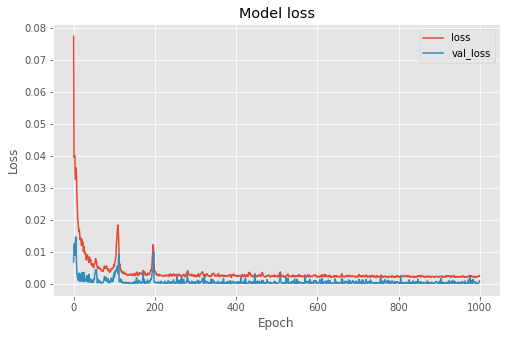

In [ ]:
plt.style.use('ggplot')
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [ ]:
from keras.models import load_model
model = load_model('./lstm.h5')

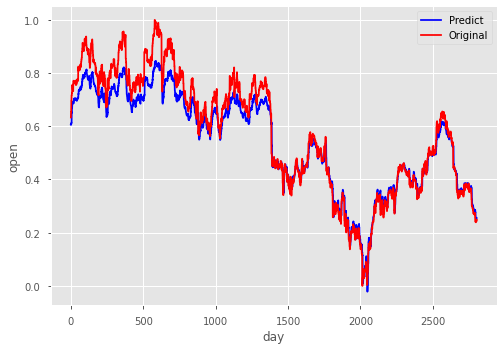

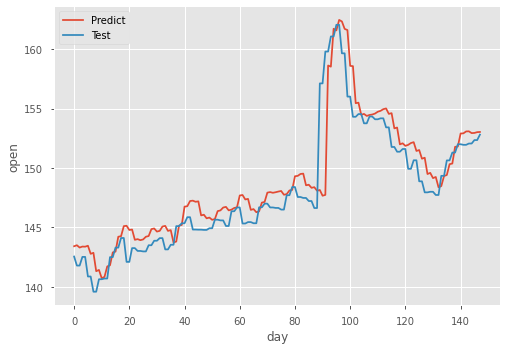

4.22096074419094

In [ ]:
pre = model.predict(x_train)
pre1 = model.predict(x_valid)
fc = np.concatenate((pre, pre1))
yreal = np.concatenate((y_train, y_valid))
pd.Series(fc.reshape(-1)).plot(color='blue', label='Predict')
pd.Series(yreal.reshape(-1)).plot(color='red', label='Original')
plt.legend()
plt.ylabel('open')
plt.xlabel('day')
plt.show()

lstm1pre = model.predict(x_test)
pre = scaler_y.inverse_transform(lstm1pre.reshape(-1, 1))
y_test_ = scaler_y.inverse_transform(y_test.reshape(-1, 1))
plt.plot(pre)
plt.plot(y_test_)
plt.ylabel('open')
plt.xlabel('day')
plt.legend(['Predict', 'Test'], loc='upper left')
plt.show()

mean_squared_error(pre,y_test_) 